In [1]:
import spacy
import pandas as pd
import numpy as np
from glob import glob
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from numpy.random import randint
from sklearn.mixture import BayesianGaussianMixture
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (14,8)

In [271]:
class textPieces(): 
    def __init__(self, author, sample=True, pieces=2): 
        self.author = author
        self.filenames = glob('data/%s*' % author)
        print('Using filenames: ', self.filenames)
        self.texts = [open(filename).read() 
                 for filename in self.filenames]
        self.lengths = [len(text) for text in self.texts]
        self.lowestLength = min(self.lengths)
        if sample: 
            self.samples = [self.sample(text) for text in self.texts]
        else: 
            self.samples = self.texts
        if pieces > 1: 
            self.labels = []
            self.pieces = []
            self.makePieces(self.filenames, self.samples, 2)
        else: 
            self.labels = [filename[6+len(self.author):-4] for filename in self.filenames]
            self.pieces = self.texts
        
    def sample(self, text): 
        """ Randomly samples from texts that are long, 
        so that we're comparing the same amount of text across documents."""
        chunkSize = self.lowestLength
        # We want a chunk of [a:b] where the max value of b is end-chunkSize
        textLength = len(text)
        maxEnd = textLength - chunkSize
        if maxEnd <= 0: 
            print('Something went wrong. maxEnd is negative or zero.')
            return text
        start = randint(0, maxEnd)
        return text[start:start+chunkSize]
    
    def makePieces(self, filenames, samples, n): 
        pieceSize = self.lowestLength / n
        for filename, sample in zip(filenames, samples): 
            for i in range(n):
                label = filename[6+len(self.author):-4] # Cut off 'data/cather-' for example and .txt
                pieceLabel = "%s-%s" % (label, i)
                start = int(i*pieceSize)
                end = int(start+pieceSize)
#                 print('Piece start: %s, piece end: %s' % (start, end))
                piece = sample[start:end]
                self.labels.append(pieceLabel)
                self.pieces.append(piece)

In [260]:
class authorAnalysis(): 
    def __init__(self, labels, docs): 
        self.labels = labels
        self.docs = docs
        self.features, self.matrix = self.vectorize()
        # Assume the date is the first four characters of the label. 
        self.pieceDates = [int(label[:4]) for label in self.labels]
        # Try to assign "early," "middle," and "late" categories (0, 1, 2) based on years. 
        self.categories = [round(cat) for cat in self.rescale(self.pieceDates, 0, 2)]
        
    @properties
    def categories(): 
        
    def vectorize(self): 
        tfidf = TfidfVectorizer()
        matrix = tfidf.fit_transform(self.docs).todense()
        features = tfidf.get_feature_names()
        return features, matrix
    
    def vectorDF(self):
        """ Just a helper to visualize the TFIDF table."""
        return pd.DataFrame(self.matrix, columns=self.features, index=self.labels)
    
    def doPCA(self): 
        pca = PCA(n_components=5)
        return pca.fit_transform(self.matrix)
    
    def plotPCA(self, labels=True, saveTo=False, clustering='bgm'): 
        pcaTable = self.doPCA()
        Xs = [thing[0] for thing in pcaTable]
        Ys = [thing[1] for thing in pcaTable]
        df = pd.DataFrame(pcaTable, index=self.labels)
        df['distance'] = np.sqrt(df[0]**2 + df[1]**2)     # Pythagorean theorem   
        if clustering == 'kmeans': 
            colors = self.kmeans()
        if clustering == 'bgm': 
            colors = self.bgm()
        ax = plt.scatter(df[0], df[1], s=self.size, c=colors)
        if labels: 
            for i, label in enumerate(self.labels):
                plt.annotate(label, (Xs[i], Ys[i]))
        if saveTo: 
            fig = ax.get_figure()
            fig.tight_layout()
            fig.savefig('pca-' + saveTo + '.png') # save it to a file
        return df.sort_values('distance', ascending=False)
    
    def rescale(self, array, low, high):
        minimum = min(array)
        maximum = max(array)
        diff = maximum - minimum
        diffScale = high - low
        return list(map( lambda x: (int(x)-minimum)*(diffScale/diff)+low, array))
    
    @property
    def size(self, by='date'): 
        if by == 'date': 
            return self.rescale(self.pieceDates, 20, 500)

    def kmeans(self): 
        pcaOut = self.doPCA()
        kmeans = KMeans(n_clusters=3)
        return kmeans.fit_predict(pcaOut)
    
    def bgm(self): 
        pcaOut = self.doPCA()
        bgm = BayesianGaussianMixture(n_components=3).fit(pcaOut)
        return bgm.predict(pcaOut)
        
    def metrics(self): 
        randK = adjusted_rand_score(self.categories, self.kmeans())
        randB = adjusted_rand_score(self.categories, self.bgm())
        print('Adjusted rand score, Kmeans: ', randK)
        print('Adjusted rand score, BGM: ', randB)
        randK = adjusted_mutual_info_score(self.categories, self.kmeans())
        randB = adjusted_mutual_info_score(self.categories, self.bgm())
        print('Adjusted mutual info score, Kmeans: ', randK)
        print('Adjusted mutual info score, BGM: ', randB)

# Proust

Using filenames:  ['data/proust-1920-guermantes.txt', 'data/proust-1919-lombre.txt', 'data/proust-1927-retrouve.txt', 'data/proust-1923-prisonniere.txt', 'data/proust-1921-sodome.txt', 'data/proust-1925-albertine.txt', 'data/proust-1913-swann.txt']
Something went wrong. maxEnd is negative or zero.
Adjusted rand score, Kmeans:  0.142857142857
Adjusted rand score, BGM:  0.142857142857
Adjusted mutual info score, Kmeans:  0.10714114934
Adjusted mutual info score, BGM:  0.10714114934


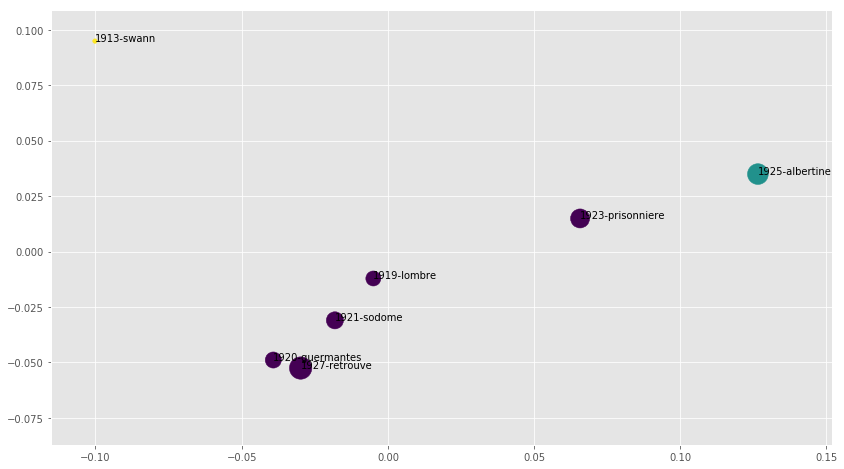

In [273]:
pieces = textPieces('proust', pieces=1)
analysis = authorAnalysis(pieces.labels, pieces.pieces)
analysis.plotPCA()
analysis.metrics()

In [265]:
analysis.metrics()

Adjusted rand score, Kmeans:  0.174228675136
Adjusted rand score, BGM:  0.240875912409
Adjusted mutual info score, Kmeans:  0.312560105468
Adjusted mutual info score, BGM:  0.114683960242


In [248]:
analysis.categories, analysis.kmeans(), analysis.bgm()

([1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 2, 0, 0],
 array([1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 2, 2], dtype=int32),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1]))

Using filenames:  ['data/dickens-1839-oliver-twist.txt', 'data/dickens-1865-our-mutual-friend.txt', 'data/dickens-1859-a-tale-of-two-cities.txt', 'data/dickens-1850-david-copperfield.txt', 'data/dickens-1861-great-expectations.txt', 'data/dickens-1870-the-mystery-of-edwin-drood.txt', 'data/dickens-1848-dombey-and-son.txt', 'data/dickens-1841-the-old-curiosity-shop.txt', 'data/dickens-1854-hard-times.txt', 'data/dickens-1844-martin-chuzzlewit.txt', 'data/dickens-1857-little-dorrit.txt', 'data/dickens-1841-barnaby-rudge.txt', 'data/dickens-1837-the-pickwick-papers.txt', 'data/dickens-1839-nicholas-nickleby.txt', 'data/dickens-1853-bleak-house.txt']
Something went wrong. maxEnd is negative or zero.
Adjusted rand score, Kmeans:  0.275698887039
Adjusted rand score, BGM:  0.0364905957878
Adjusted mutual info score, Kmeans:  0.345717152833
Adjusted mutual info score, BGM:  0.40474689146


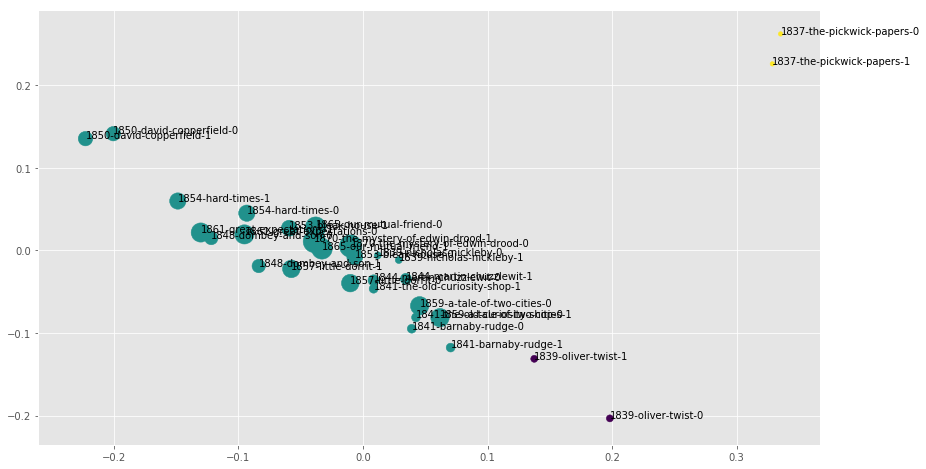

In [270]:
pieces = textPieces('dickens')
analysis = authorAnalysis(pieces.labels, pieces.pieces)
analysis.plotPCA()
analysis.metrics()

Using filenames:  ['data/conrad-1897-the-nigger-of-the-narcissus.txt', 'data/conrad-1907-the-secret-agent.txt', 'data/conrad-1911-under-western-eyes.txt', 'data/conrad-1895-almayers-folly.txt', 'data/conrad-1900-lord-jim.txt', 'data/conrad-1902-typhoon.txt', 'data/conrad-1920-the-rescue.txt', 'data/conrad-1919-the-arrow-of-gold.txt', 'data/conrad-1925-suspense.txt', 'data/conrad-1896-an-outcast-of-the-islands.txt', 'data/conrad-1899-heart-of-darkness.txt', 'data/conrad-1913-chance.txt', 'data/conrad-1923-the-rover.txt', 'data/conrad-1902-the-end-of-the-tether.txt', 'data/conrad-1917-the-shadow-line.txt', 'data/conrad-1904-nostromo.txt', 'data/conrad-1915-victory.txt']
Something went wrong. maxEnd is negative or zero.


,0,1,distance
1907-the-secret-agent-0,0.156465,0.463280,0.488988
1907-the-secret-agent-1,0.192094,0.406900,0.449964
1913-chance-1,0.295279,-0.021493,0.296060
1919-the-arrow-of-gold-0,0.262526,-0.095141,0.279234
1911-under-western-eyes-1,0.248124,-0.124498,0.277606
1919-the-arrow-of-gold-1,0.238465,-0.113711,0.264190
1911-under-western-eyes-0,0.204772,-0.123719,0.239245
1920-the-rescue-1,-0.184354,-0.000568,0.184355
1895-almayers-folly-1,-0.170218,0.039630,0.174770
1895-almayers-folly-0,-0.160739,0.057453,0.170698


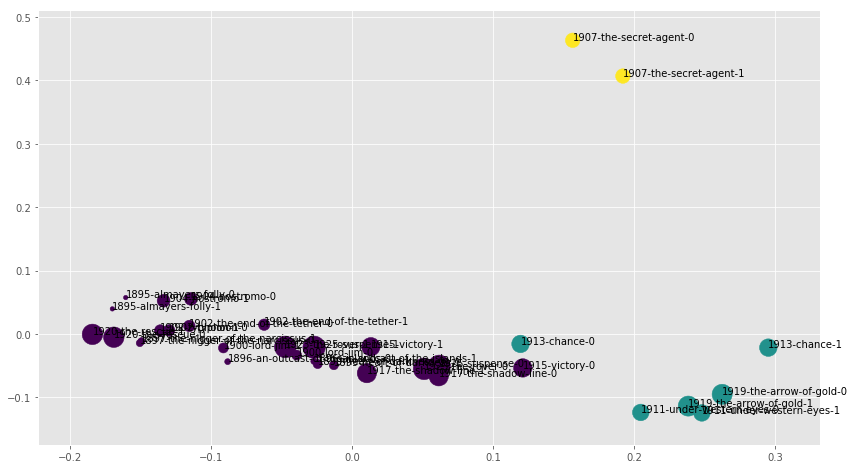

In [252]:
pieces = textPieces('conrad')
analysis = authorAnalysis(pieces.labels, pieces.pieces)
analysis.plotPCA()

Using filenames:  ['data/genet-1986-captif-amoreux.txt', 'data/genet-1947-pompes-funèbres.txt', 'data/genet-1949-journal-du-voleur.txt', 'data/genet-1947-querelle-de-brest.txt', 'data/genet-1946-miracle-de-la-rose.txt', 'data/genet-1942-notre-dame.txt']
Something went wrong. maxEnd is negative or zero.
Adjusted rand score, Kmeans:  0.142857142857
Adjusted rand score, BGM:  0.142857142857
Adjusted mutual info score, Kmeans:  0.122993414354
Adjusted mutual info score, BGM:  0.122993414354


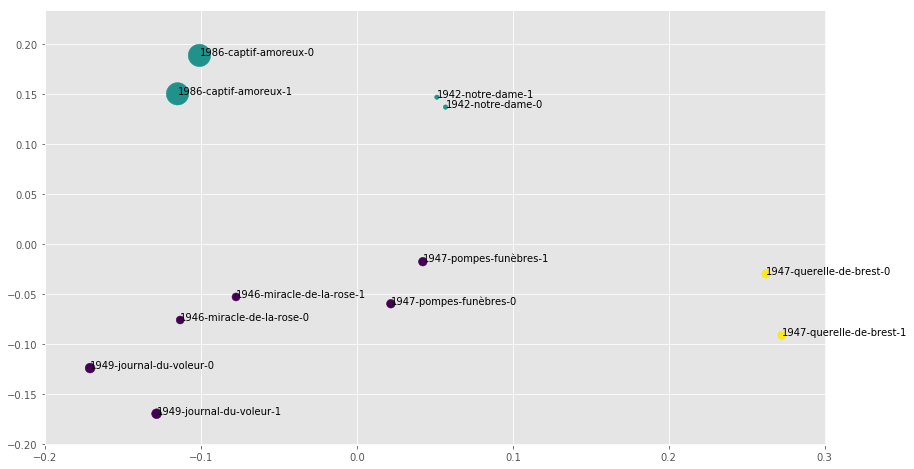

In [258]:
pieces = textPieces('genet')
analysis = authorAnalysis(pieces.labels, pieces.pieces)
analysis.plotPCA()
analysis.metrics()

In [259]:
analysis.labels, analysis.categories, analysis.bgm()

(['1986-captif-amoreux-0',
  '1986-captif-amoreux-1',
  '1947-pompes-funèbres-0',
  '1947-pompes-funèbres-1',
  '1949-journal-du-voleur-0',
  '1949-journal-du-voleur-1',
  '1947-querelle-de-brest-0',
  '1947-querelle-de-brest-1',
  '1946-miracle-de-la-rose-0',
  '1946-miracle-de-la-rose-1',
  '1942-notre-dame-0',
  '1942-notre-dame-1'],
 [2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 array([2, 2, 1, 1, 1, 1, 0, 0, 1, 1, 2, 2]))